In [ ]:
# TTS_PATH = "/home/erogol/projects/"

In [8]:
import os
import sys
import librosa
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
from matplotlib import pylab as plt
from collections import Counter
from TTS.config.shared_configs import BaseDatasetConfig
from TTS.tts.datasets import load_tts_samples
from TTS.tts.datasets.formatters import *
%matplotlib inline

In [13]:
NUM_PROC = 8
DATASET_CONFIG = BaseDatasetConfig(
    formatter="ljspeech", meta_file_train="metadata.csv", path="/mnt/c/users/marco/desktop/Pruebas"
)

In [14]:
def formatter(root_path, meta_file, **kwargs):  # pylint: disable=unused-argument
    txt_file = os.path.join(root_path, meta_file)
    items = []
    speaker_name = "myspeaker"
    with open(txt_file, "r", encoding="utf-8") as ttf:
        for line in ttf:
            cols = line.split("|")
            wav_file = os.path.join(root_path, "wavs", cols[0] + ".wav")            
            text = cols[1]
            items.append({"text": text, "audio_file": wav_file, "speaker_name": speaker_name, "root_path": root_path})
    return items

In [15]:
# use your own preprocessor at this stage - TTS/datasets/proprocess.py
train_samples, eval_samples = load_tts_samples(DATASET_CONFIG, eval_split=True, formatter=formatter)
if eval_samples is not None:
    items = train_samples + eval_samples
else:
    items = train_samples
print(" > Number of audio files: {}".format(len(items)))
print(items[1])

 | > Found 400 files in /mnt/c/users/marco/desktop/Pruebas
 > Number of audio files: 400
{'text': 'Mi amigo me invitó a su fiesta de cumpleaños el sábado.', 'audio_file': '/mnt/c/users/marco/desktop/Pruebas/wavs/dereck61.wav', 'speaker_name': 'myspeaker', 'root_path': '/mnt/c/users/marco/desktop/Pruebas', 'language': '', 'audio_unique_name': '#wavs/dereck61'}


In [17]:
# check wavs if exist
wav_files = []
for item in items:
    wav_file = item["audio_file"].strip()
    wav_files.append(wav_file)
    if not os.path.exists(wav_file):
        print(wav_file)

In [18]:
# show duplicate items
c = Counter(wav_files)
print([item for item, count in c.items() if count > 1])

[]


In [19]:
item

{'text': '¡Ten cuidado con el vaso, se puede romper!',
 'audio_file': '/mnt/c/users/marco/desktop/Pruebas/wavs/dereck197.wav',
 'speaker_name': 'myspeaker',
 'root_path': '/mnt/c/users/marco/desktop/Pruebas',
 'language': '',
 'audio_unique_name': '#wavs/dereck197'}

In [20]:
def load_item(item):
    text = item["text"].strip()
    file_name = item["audio_file"].strip()
    audio, sr = librosa.load(file_name, sr=None)
    audio_len = len(audio) / sr
    text_len = len(text)
    return file_name, text, text_len, audio, audio_len

# This will take a while depending on size of dataset
if NUM_PROC == 1:
    data = []
    for m in tqdm(items):
        data += [load_item(m)]
else:
    with Pool(8) as p:
        data = list(tqdm(p.imap(load_item, items), total=len(items)))

100%|██████████| 400/400 [00:03<00:00, 112.88it/s]


In [21]:
# count words in the dataset
w_count = Counter()
for item in tqdm(data):
    text = item[1].lower().strip()
    for word in text.split():
        w_count[word] += 1
print(" > Number of words: {}".format(len(w_count)))

100%|██████████| 400/400 [00:00<00:00, 104635.25it/s]

 > Number of words: 1352


In [22]:
text_vs_durs = {}  # text length vs audio duration
text_len_counter = Counter()  # number of sentences with the keyed length
for item in tqdm(data):
    text = item[1].lower().strip()
    text_len = len(text)
    text_len_counter[text_len] += 1
    audio_len = item[-1]
    try:
        text_vs_durs[text_len] += [audio_len]
    except:
        text_vs_durs[text_len] = [audio_len]

100%|██████████| 400/400 [00:00<00:00, 309428.55it/s]


In [23]:
# text_len vs avg_audio_len, median_audio_len, std_audio_len
text_vs_avg = {}
text_vs_median = {}
text_vs_std = {}
for key, durs in text_vs_durs.items():
    text_vs_avg[key] = np.mean(durs)
    text_vs_median[key] = np.median(durs)
    text_vs_std[key] = np.std(durs)

### Avg audio length per char

In [24]:
for item in data:
    if item[-1] < 2:
        print(item)

In [25]:
sec_per_chars = []
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    sec_per_chars.append(sec_per_char)
# sec_per_char /= len(data)
# print(sec_per_char)

In [26]:
mean = np.mean(sec_per_chars)
std = np.std(sec_per_chars)
print(mean)
print(std)

0.07533183103889562
0.008123064086358702


In [45]:
dist = norm(mean, std)

# find irregular instances long or short voice durations
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    pdf =norm.pdf(sec_per_char)
    if pdf < 0.39:
        print(item)

### Plot Dataset Statistics

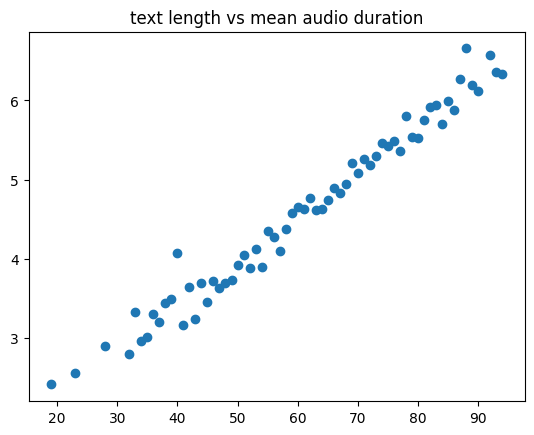

In [28]:
plt.title("text length vs mean audio duration")
plt.scatter(list(text_vs_avg.keys()), list(text_vs_avg.values()))

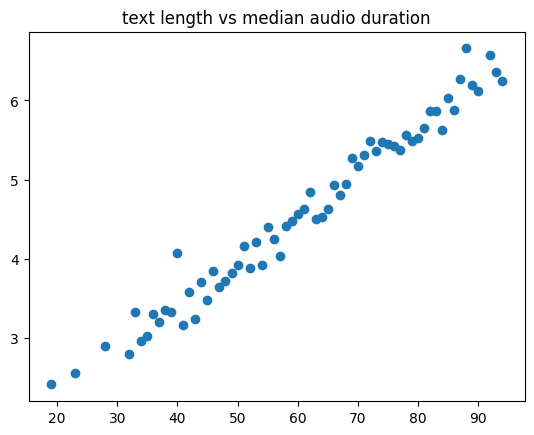

In [29]:
plt.title("text length vs median audio duration")
plt.scatter(list(text_vs_median.keys()), list(text_vs_median.values()))

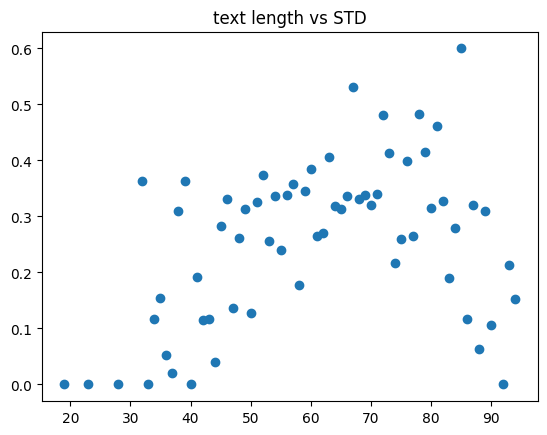

In [30]:
plt.title("text length vs STD")
plt.scatter(list(text_vs_std.keys()), list(text_vs_std.values()))

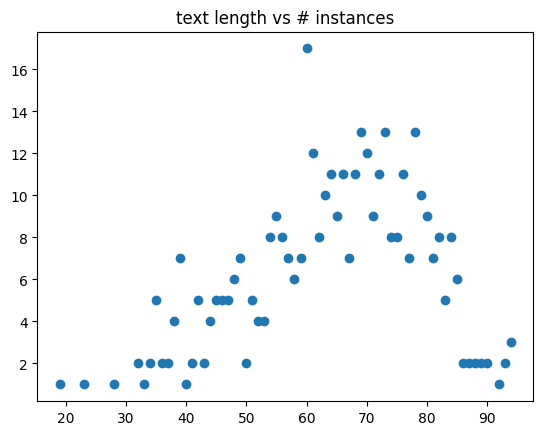

In [31]:
plt.title("text length vs # instances")
plt.scatter(list(text_len_counter.keys()), list(text_len_counter.values()))

### Check words frequencies

In [43]:
w_count_df = pd.DataFrame.from_dict(w_count, orient='index')
w_count_df.sort_values(0, ascending=False, inplace=True)

In [41]:
w_count_df

,0
el,244
la,204
de,194
a,126
en,123
...,...
bebidas,1
calientes,1
dulces.,1
desayunar,1


In [44]:
# check a certain word
w_count_df.at['el', 0]

244

<Axes: >

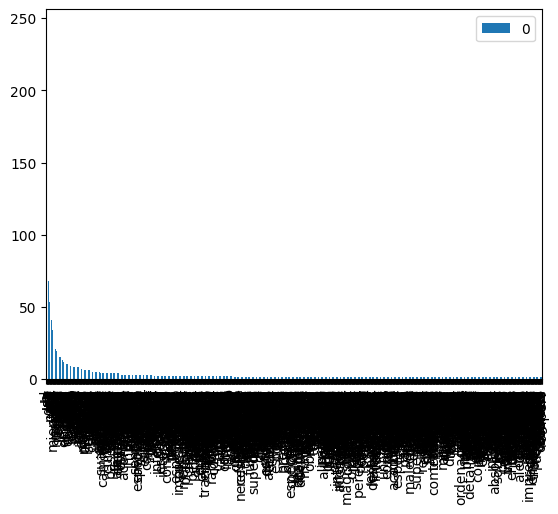

In [35]:
# fequency bar plot - it takes time!!
w_count_df.plot.bar()